<a href="https://colab.research.google.com/github/IsaacFigNewton/Analyzing-Hate-Crime-Data/blob/main/Hate_Crime_Data_Exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#TODO:
####Fix the excessive number of bias/target groups
####Add the ethnicity_race_cols to demo_df

#Import Stuff

###Import all libraries

In [1]:
import pandas as pd
import sklearn as sk
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import altair as alt
import re

###Import datasets

In [2]:
crime_df = pd.read_csv("https://raw.githubusercontent.com/IsaacFigNewton/Analyzing-Hate-Crime-Data/main/hate_crime/hate_crime.csv", on_bad_lines='skip')
city_demo_df = pd.read_csv("https://raw.githubusercontent.com/IsaacFigNewton/Analyzing-Hate-Crime-Data/main/demographics/city/ACSST1Y2022.S0101-Data.csv", on_bad_lines='skip')
county_demo_df = pd.read_csv("https://raw.githubusercontent.com/IsaacFigNewton/Analyzing-Hate-Crime-Data/main/demographics/county/ACSDP1Y2022.DP05-Data.csv", on_bad_lines='skip')

#Data Cleaning

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
#only consider 2022 crime data from cities and counties
crime_df = crime_df[(crime_df['data_year'] == 2022) & ((crime_df['agency_type_name'] == "City") | (crime_df['agency_type_name'] == "County"))]

##Clean city and county demographic datasets

In [5]:
# use the entries of the first row as the column headers for easier management
def fixHeaders(df):
  new_headers = df.iloc[0]
  new_df = df[1:]
  new_df.columns = new_headers
  return new_df

In [6]:
#fix the headers
city_demo_df = fixHeaders(city_demo_df)
county_demo_df = fixHeaders(county_demo_df)

In [7]:
def split_area_name(area):
    result = [np.nan, np.nan, np.nan]
    if ", " in area:
        result = area.split(", ") + [np.nan]
    if " city" in result[0].lower():
        result[0] = result[0][0:-5]
        result[2] = result[1]
        result[1] = "City"
    elif " county" in result[0].lower():
        result[0] = result[0][0:-7]
        result[2] = result[1]
        result[1] = "County"

    return result + [np.nan] * (3 - len(result))

def splitArea(df):
    df[["pug_agency_name", "agency_type_name", "state_name"]] = df["Geographic Area Name"].map(split_area_name).apply(pd.Series)

In [8]:
splitArea(city_demo_df)
splitArea(county_demo_df)

# city_demo_df.head()

<ipython-input-7-05c1ba8e5616>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[["pug_agency_name", "agency_type_name", "state_name"]] = df["Geographic Area Name"].map(split_area_name).apply(pd.Series)
<ipython-input-7-05c1ba8e5616>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[["pug_agency_name", "agency_type_name", "state_name"]] = df["Geographic Area Name"].map(split_area_name).apply(pd.Series)
<ipython-input-7-05c1ba8e5616>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of

##Clean crime dataset

In [9]:
def split_incident_date(date):
    result = date.split("-")

    return result + [np.nan] * (3 - len(result))

crime_df[["data_year", "incident_month", "incident_day"]] = crime_df["incident_date"].map(split_incident_date).apply(pd.Series)

###Break up bias descriptions into dummy columns

In [42]:
def split_bias_desc(desc):
  # break up the biases into individual biases
  biases = desc.split(";")
  for i in range(len(biases)):
      biases[i] = biases[i]\
                    .replace("(Male)", "")\
                    .replace("(Female)", "")\
                    .replace("Lesbian, Gay, Bisexual, or Transgender (Mixed Group)", "LGBTQ")\
                    .strip()

  # add placeholders
  biases = biases + [0] * (5 - len(biases))

  return biases

# TODO: find max bias count in mapping function above?
max_bias_count = 5

bias_cols = ["bias" + str(i) for i in range(max_bias_count)]
crime_df[bias_cols] = crime_df["bias_desc"]\
                          .map(split_bias_desc)\
                          .apply(pd.Series)

# remove the "0" column, which I'm not entirely sure why exists
if "0" in crime_df.columns:
  crime_df = crime_df.drop(columns=["0"])

AttributeError: 'float' object has no attribute 'split'

In [11]:
#create a list of all biases
all_biases = []
for col in bias_cols:
  all_biases.extend(crime_df[col].unique())

# create a set of just the unique ones
unique_biases = set(all_biases)

# remove 0, which got in there somehow
unique_biases.remove(0)

In [12]:
unique_biases

{'Anti-American Indian or Alaska Native',
 'Anti-Arab',
 'Anti-Asian',
 'Anti-Atheism/Agnosticism',
 'Anti-Bisexual',
 'Anti-Black or African American',
 'Anti-Buddhist',
 'Anti-Catholic',
 'Anti-Church of Jesus Christ',
 'Anti-Eastern Orthodox (Russian, Greek, Other)',
 'Anti-Female',
 'Anti-Gay',
 'Anti-Gender Non-Conforming',
 'Anti-Heterosexual',
 'Anti-Hindu',
 'Anti-Hispanic or Latino',
 'Anti-Islamic (Muslim)',
 "Anti-Jehovah's Witness",
 'Anti-Jewish',
 'Anti-LGBTQ',
 'Anti-Lesbian',
 'Anti-Male',
 'Anti-Mental Disability',
 'Anti-Multiple Races, Group',
 'Anti-Multiple Religions, Group',
 'Anti-Native Hawaiian or Other Pacific Islander',
 'Anti-Other Christian',
 'Anti-Other Race/Ethnicity/Ancestry',
 'Anti-Other Religion',
 'Anti-Physical Disability',
 'Anti-Protestant',
 'Anti-Sikh',
 'Anti-Transgender',
 'Anti-White'}

In [13]:
# create dummy columns for all hate crime biases
dummies = pd.get_dummies(list(unique_biases))

# combine the dummy columns with crime_df
crime_df = pd.concat([crime_df, dummies], axis=1)

# set all dummy values to 0
crime_df.loc[:, dummies.columns] = 0

In [14]:
#set dummy column values according to biases parsed from bias_desc

# for each entry
for i in crime_df.index:
    # for each bias column
    for j in range(0, 5):
        bias = crime_df.loc[i]["bias" + str(j)]
        if bias in unique_biases:
            # Use the iloc method to access the DataFrame by row and column indices
            crime_df.loc[i, bias] = 1


In [15]:
crime_df.head()

,incident_id,data_year,ori,pug_agency_name,pub_agency_unit,agency_type_name,state_abbr,state_name,division_name,region_name,population_group_code,population_group_description,incident_date,adult_victim_count,juvenile_victim_count,total_offender_count,adult_offender_count,juvenile_offender_count,offender_race,offender_ethnicity,victim_count,offense_name,total_individual_victims,location_name,bias_desc,victim_types,multiple_offense,multiple_bias,incident_month,incident_day,bias0,bias1,bias2,bias3,bias4,Anti-American Indian or Alaska Native,Anti-Arab,Anti-Asian,Anti-Atheism/Agnosticism,Anti-Bisexual,Anti-Black or African American,Anti-Buddhist,Anti-Catholic,Anti-Church of Jesus Christ,"Anti-Eastern Orthodox (Russian, Greek, Other)",Anti-Female,Anti-Gay,Anti-Gender Non-Conforming,Anti-Heterosexual,Anti-Hindu,Anti-Hispanic or Latino,Anti-Islamic (Muslim),Anti-Jehovah's Witness,Anti-Jewish,Anti-LGBTQ,Anti-Lesbian,Anti-Male,Anti-Mental Disability,"Anti-Multiple Races, Group","Anti-Multiple Religions, Group",Anti-Native Hawaiian or Other Pacific Islander,Anti-Other Christian,Anti-Other Race/Ethnicity/Ancestry,Anti-Other Religion,Anti-Physical Disability,Anti-Protestant,Anti-Sikh,Anti-Transgender,Anti-White
230020,1476719.0,2022,AK0010500,Kodiak,NaN,City,AK,Alaska,Pacific,West,6,"Cities from 2,500 thru 9,999",2022-07-31,1.0,0.0,1.0,1.0,0.0,American Indian or Alaska Native,Not Specified,1.0,Destruction/Damage/Vandalism of Property,1.0,Residence/Home,"Anti-Lesbian, Gay, Bisexual, or Transgender (M...",Individual,S,S,07,31,Anti-LGBTQ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
230021,1483026.0,2022,AK0015600,Wasilla,NaN,City,AK,Alaska,Pacific,West,6,"Cities from 2,500 thru 9,999",2022-10-06,0.0,0.0,0.0,NaN,NaN,Not Specified,Not Specified,1.0,Destruction/Damage/Vandalism of Property,0.0,Church/Synagogue/Temple/Mosque,Anti-Other Christian,Religious Organization,S,S,10,06,Anti-Other Christian,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
230022,1484192.0,2022,AK0010100,Anchorage,NaN,City,AK,Alaska,Pacific,West,1C,"Cities from 250,000 thru 499,999",2022-03-25,1.0,0.0,0.0,0.0,0.0,Unknown,Unknown,1.0,Intimidation,1.0,Community Center,Anti-Jewish,Individual,S,S,03,25,Anti-Jewish,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
230023,1484193.0,2022,AK0010100,Anchorage,NaN,City,AK,Alaska,Pacific,West,1C,"Cities from 250,000 thru 499,999",2022-06-30,NaN,NaN,0.0,0.0,0.0,Unknown,Unknown,1.0,Destruction/Damage/Vandalism of Property,NaN,Church/Synagogue/Temple/Mosque,Anti-Other Christian,Religious Organization,S,S,06,30,Anti-Other Christian,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
230024,1484194.0,2022,AK0010100,Anchorage,NaN,City,AK,Alaska,Pacific,West,1C,"Cities from 250,000 thru 499,999",2022-07-05,NaN,NaN,0.0,0.0,0.0,Unknown,Unknown,1.0,Destruction/Damage/Vandalism of Property,NaN,Church/Synagogue/Temple/Mosque,Anti-Jewish,Business,S,S,07,05,Anti-Jewish,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [16]:
def fix_column_names(df):
  removalList = {"SEX AND AGE!!", "SEX AND ", "Estimate!!", "Total!!", "Total population!!", "CITIZEN, VOTING AGE POPULATION!!", "AGE!!"}

  new_cols = []
  for col in df.columns:
    col = str(col)
    for term in removalList:
      if term in col:
        col = col.replace(term, "")
    new_cols.append(col)

  return new_cols

county_demo_df.columns = fix_column_names(county_demo_df)
city_demo_df.columns = fix_column_names(city_demo_df)

In [17]:
#combine the city_df age-related columns as needed to merge better with the county_demo_df
def combine_city_df_cols(df_s0101):
    formatted_df = df_s0101.copy(deep=True)

    formatted_df['25 to 34 years'] = df_s0101['25 to 29 years'] + df_s0101['30 to 34 years']
    formatted_df['35 to 44 years'] = df_s0101['35 to 39 years'] + df_s0101['40 to 44 years']
    formatted_df['45 to 54 years'] = df_s0101['45 to 49 years'] + df_s0101['50 to 54 years']
    formatted_df['65 to 74 years'] = df_s0101['65 to 69 years'] + df_s0101['70 to 74 years']
    formatted_df['75 to 84 years'] = df_s0101['75 to 79 years'] + df_s0101['80 to 84 years']

    return formatted_df

city_demo_df = combine_city_df_cols(city_demo_df)
# city_demo_df

In [18]:
# fix any missing values
city_demo_df = city_demo_df.replace("(X)", np.nan)
county_demo_df = county_demo_df.replace("(X)", np.nan)

##Combine the datasets

In [19]:
ethnicity_race_cols = pd.read_csv("https://raw.githubusercontent.com/IsaacFigNewton/Analyzing-Hate-Crime-Data/main/demographics/county/ethnicity_race_col_names")["One race"]
ethnicity_race_cols

0                                     Two or More Races
1                                              One race
2                                             One White
3                         One Black or African American
4                 One American Indian and Alaska Native
5     One American Indian and Alaska Native!!Cheroke...
6     One American Indian and Alaska Native!!Chippew...
7     One American Indian and Alaska Native!!Navajo ...
8     One American Indian and Alaska Native!!Sioux t...
9                                             One Asian
10                              One Asian!!Asian Indian
11                                   One Asian!!Chinese
12                                  One Asian!!Filipino
13                                  One Asian!!Japanese
14                                    One Asian!!Korean
15                                One Asian!!Vietnamese
16                               One Asian!!Other Asian
17       One Native Hawaiian and Other Pacific I

In [20]:
# Create new columns that combine data shared between all the city and county entries
overlapping_columns = set(city_demo_df.columns).intersection(set(county_demo_df.columns))

# include overlapping data and race and ethnicity data from the county dataset
print(overlapping_columns.union(ethnicity_race_cols))
demo_df = pd.concat([city_demo_df[list(overlapping_columns)], county_demo_df[list(overlapping_columns)]])

{'55 to 59 years', '35 to 44 years', 'One Native Hawaiian and Other Pacific Islander!!Other Native Hawaiian and Other Pacific Islander', 'Percent!!55 to 59 years', 'White and Some Other Race', 'pug_agency_name', 'Percent!!60 to 64 years', 'HISPANIC OR LATINO AND Not Hispanic or Latino!!Some Other Race alone', 'Race alone or in combination with one or more other races!!Some Other Race', 'HISPANIC OR LATINO AND Hispanic or Latino (of any race)!!Puerto Rican', 'Margin of Error!!55 to 59 years', 'One Some Other Race', 'Margin of Error!!Under 5 years', 'One Native Hawaiian and Other Pacific Islander!!Chamorro', 'HISPANIC OR LATINO AND Not Hispanic or Latino!!American Indian and Alaska Native alone', 'One race', 'Margin of Error!!85 years and over', '85 years and over', '65 to 74 years', 'Margin of Error!!60 to 64 years', 'HISPANIC OR LATINO AND Not Hispanic or Latino!!White alone', 'HISPANIC OR LATINO AND Not Hispanic or Latino!!Black or African American alone', 'One Asian!!Vietnamese', 'Ma

In [21]:
# combine the crime and population datasets
merged_df = pd.merge(crime_df, demo_df, on=["pug_agency_name", "agency_type_name", "state_name"])

##Clean the merged dataset

In [22]:
merged_df.drop(["ori", "state_abbr", "population_group_code", "pub_agency_unit",
                "nan", "Geography", "Percent!!Total population", "population_group_description",
                "Geographic Area Name", "incident_date", "pub_agency_unit"], axis=1, inplace=True)
merged_df.drop(list(merged_df.filter(regex = "Margin of Error")), axis = 1, inplace = True)

In [23]:
# Convert object columns to string dtype
object_columns = ["pug_agency_name", "agency_type_name", "state_name", "division_name", "offender_race",
                  "offender_ethnicity", "offense_name", "location_name", "bias_desc", "victim_types", "multiple_offense",
                  "multiple_bias"]
merged_df[object_columns] = merged_df[object_columns].astype(str)

In [24]:
int_columns = ["Total population", "Under 5 years", "5 to 9 years", "45 to 54 years", "10 to 14 years", "75 to 84 years", "60 to 64 years",\
                      "25 to 34 years", "15 to 19 years", "20 to 24 years", "35 to 44 years", "55 to 59 years", "65 to 74 years",\
                      "85 years and over", "incident_month", "incident_day"] + list(unique_biases)

In [25]:
non_na_cols = merged_df.replace([np.inf, -np.inf], np.nan).dropna(subset=int_columns).columns

# Find the row with the 'Mobile' value
mobile_row = merged_df[merged_df[non_na_cols] == 'Mobile'].index

# Drop the row with the 'Mobile' value
merged_df.drop(mobile_row, inplace=True)

# Recalculate the non_na_cols
non_na_cols = merged_df.dropna(subset=int_columns).columns

# Convert the non_na_cols column to integers
merged_df[non_na_cols] = merged_df[non_na_cols].astype(int)

# Explore the Data

##Individual Datasets

###Hate Crime Dataset

In [26]:
crime_df.head()

,incident_id,data_year,ori,pug_agency_name,pub_agency_unit,agency_type_name,state_abbr,state_name,division_name,region_name,population_group_code,population_group_description,incident_date,adult_victim_count,juvenile_victim_count,total_offender_count,adult_offender_count,juvenile_offender_count,offender_race,offender_ethnicity,victim_count,offense_name,total_individual_victims,location_name,bias_desc,victim_types,multiple_offense,multiple_bias,incident_month,incident_day,bias0,bias1,bias2,bias3,bias4,Anti-American Indian or Alaska Native,Anti-Arab,Anti-Asian,Anti-Atheism/Agnosticism,Anti-Bisexual,Anti-Black or African American,Anti-Buddhist,Anti-Catholic,Anti-Church of Jesus Christ,"Anti-Eastern Orthodox (Russian, Greek, Other)",Anti-Female,Anti-Gay,Anti-Gender Non-Conforming,Anti-Heterosexual,Anti-Hindu,Anti-Hispanic or Latino,Anti-Islamic (Muslim),Anti-Jehovah's Witness,Anti-Jewish,Anti-LGBTQ,Anti-Lesbian,Anti-Male,Anti-Mental Disability,"Anti-Multiple Races, Group","Anti-Multiple Religions, Group",Anti-Native Hawaiian or Other Pacific Islander,Anti-Other Christian,Anti-Other Race/Ethnicity/Ancestry,Anti-Other Religion,Anti-Physical Disability,Anti-Protestant,Anti-Sikh,Anti-Transgender,Anti-White
230020,1476719.0,2022,AK0010500,Kodiak,NaN,City,AK,Alaska,Pacific,West,6,"Cities from 2,500 thru 9,999",2022-07-31,1.0,0.0,1.0,1.0,0.0,American Indian or Alaska Native,Not Specified,1.0,Destruction/Damage/Vandalism of Property,1.0,Residence/Home,"Anti-Lesbian, Gay, Bisexual, or Transgender (M...",Individual,S,S,07,31,Anti-LGBTQ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
230021,1483026.0,2022,AK0015600,Wasilla,NaN,City,AK,Alaska,Pacific,West,6,"Cities from 2,500 thru 9,999",2022-10-06,0.0,0.0,0.0,NaN,NaN,Not Specified,Not Specified,1.0,Destruction/Damage/Vandalism of Property,0.0,Church/Synagogue/Temple/Mosque,Anti-Other Christian,Religious Organization,S,S,10,06,Anti-Other Christian,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
230022,1484192.0,2022,AK0010100,Anchorage,NaN,City,AK,Alaska,Pacific,West,1C,"Cities from 250,000 thru 499,999",2022-03-25,1.0,0.0,0.0,0.0,0.0,Unknown,Unknown,1.0,Intimidation,1.0,Community Center,Anti-Jewish,Individual,S,S,03,25,Anti-Jewish,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
230023,1484193.0,2022,AK0010100,Anchorage,NaN,City,AK,Alaska,Pacific,West,1C,"Cities from 250,000 thru 499,999",2022-06-30,NaN,NaN,0.0,0.0,0.0,Unknown,Unknown,1.0,Destruction/Damage/Vandalism of Property,NaN,Church/Synagogue/Temple/Mosque,Anti-Other Christian,Religious Organization,S,S,06,30,Anti-Other Christian,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
230024,1484194.0,2022,AK0010100,Anchorage,NaN,City,AK,Alaska,Pacific,West,1C,"Cities from 250,000 thru 499,999",2022-07-05,NaN,NaN,0.0,0.0,0.0,Unknown,Unknown,1.0,Destruction/Damage/Vandalism of Property,NaN,Church/Synagogue/Temple/Mosque,Anti-Jewish,Business,S,S,07,05,Anti-Jewish,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


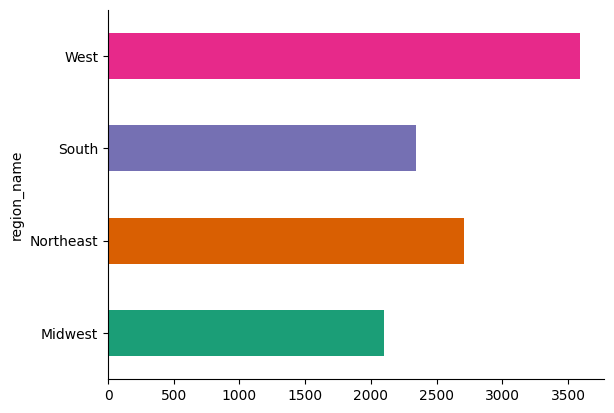

In [27]:
crime_df.groupby('region_name').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

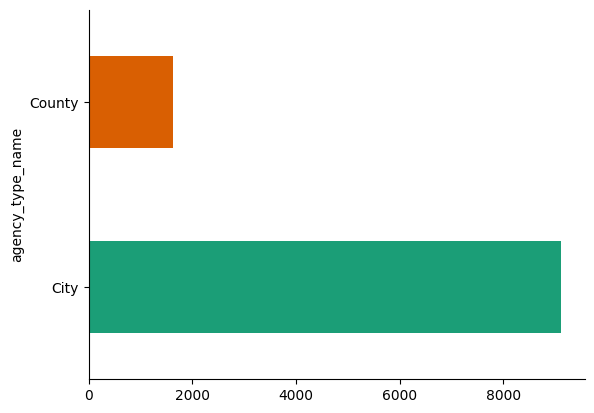

In [28]:
crime_df.groupby('agency_type_name').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

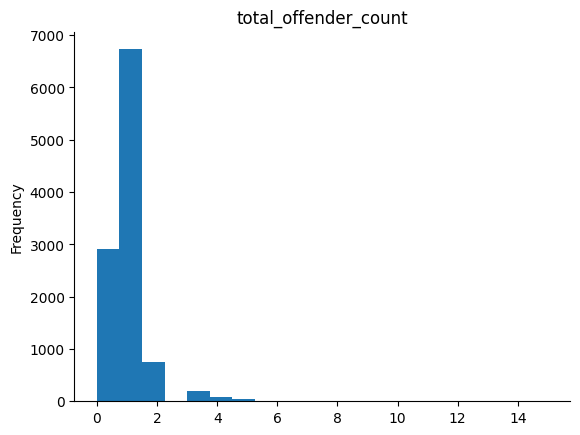

In [29]:
crime_df['total_offender_count'].plot(kind='hist', bins=20, title='total_offender_count')
plt.gca().spines[['top', 'right',]].set_visible(False)

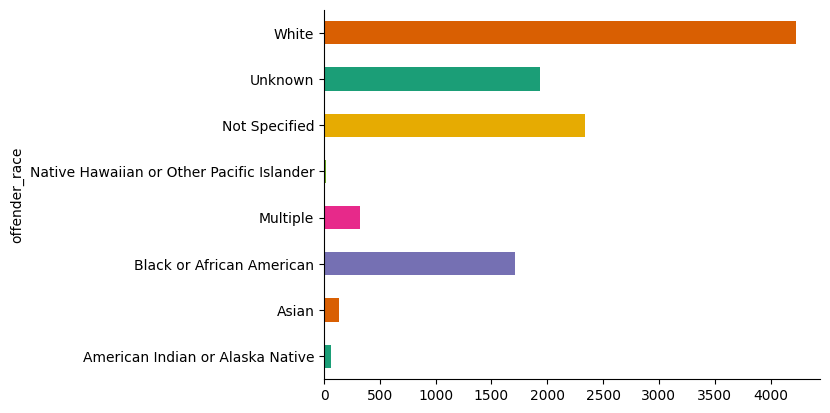

In [30]:
crime_df.groupby('offender_race').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [31]:
#TODO: Fix the excessive number of bias/target groups
# create a list of all individual biases
# create new dummy columns for each bias that hold boolean values, set to False by default
# parse the bias columns' truth values from the bias_desc column

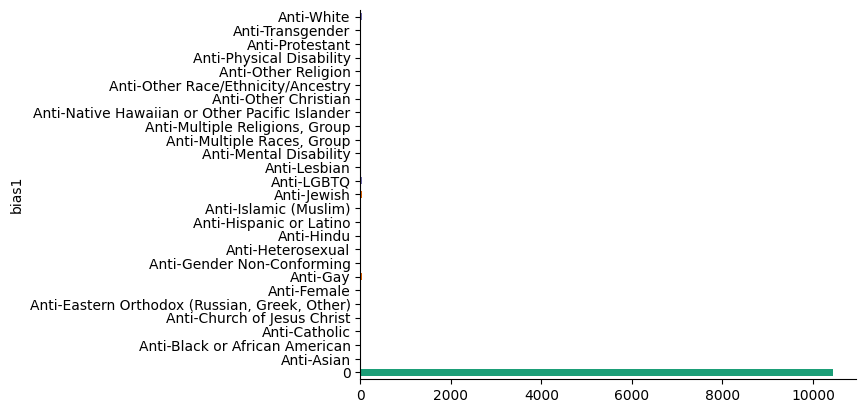

In [32]:
crime_df.groupby('bias1').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

<Axes: title={'center': 'adult_victim_count'}, ylabel='Frequency'>

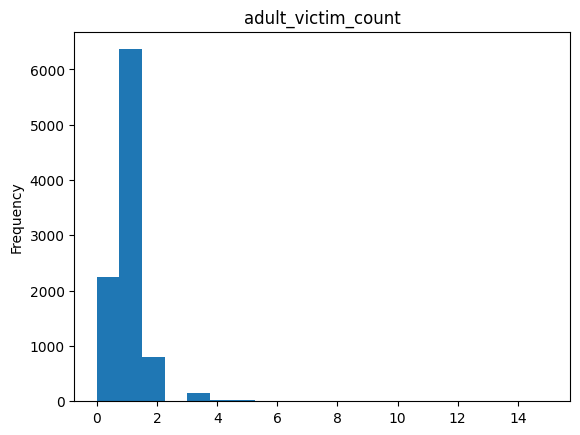

In [33]:
crime_df['adult_victim_count'].plot.hist(bins=20, title='adult_victim_count')

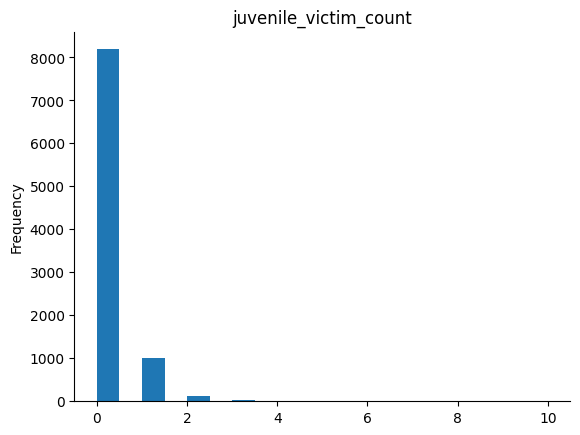

In [34]:
crime_df['juvenile_victim_count'].plot(kind='hist', bins=20, title='juvenile_victim_count')
plt.gca().spines[['top', 'right',]].set_visible(False)

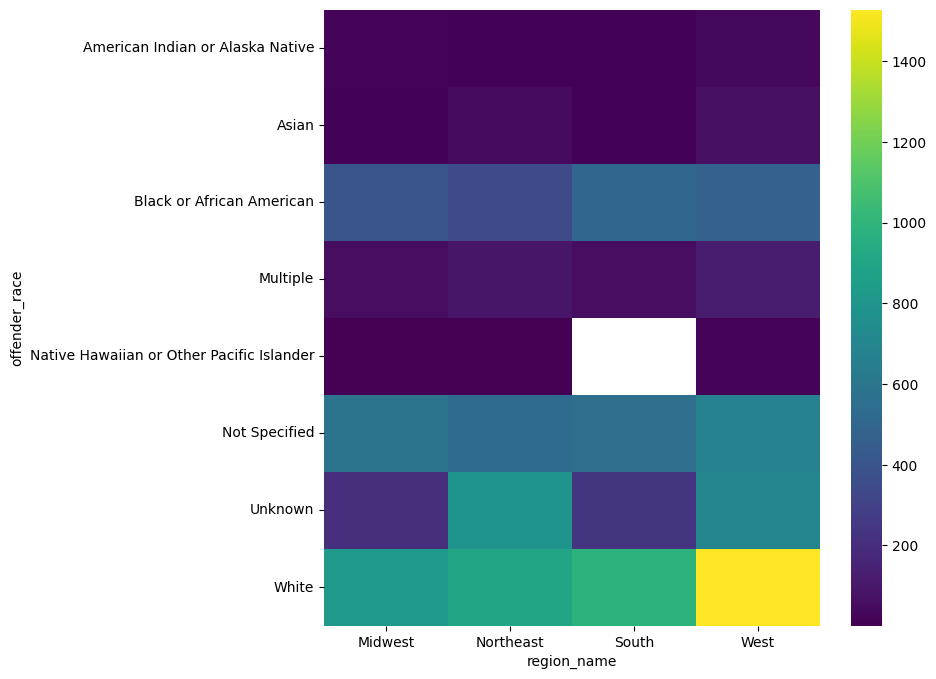

In [35]:
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['offender_race'].value_counts()
    for x_label, grp in crime_df.groupby('region_name')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('region_name')
_ = plt.ylabel('offender_race')

###City Demographics Dataset

In [36]:
city_demo_df.head()

,Geography,Geographic Area Name,Total population,Margin of Error!!Total population,Under 5 years,Margin of Error!!Under 5 years,5 to 9 years,Margin of Error!!5 to 9 years,10 to 14 years,Margin of Error!!10 to 14 years,15 to 19 years,Margin of Error!!15 to 19 years,20 to 24 years,Margin of Error!!20 to 24 years,25 to 29 years,Margin of Error!!25 to 29 years,30 to 34 years,Margin of Error!!30 to 34 years,35 to 39 years,Margin of Error!!35 to 39 years,40 to 44 years,Margin of Error!!40 to 44 years,45 to 49 years,Margin of Error!!45 to 49 years,50 to 54 years,Margin of Error!!50 to 54 years,55 to 59 years,Margin of Error!!55 to 59 years,60 to 64 years,Margin of Error!!60 to 64 years,65 to 69 years,Margin of Error!!65 to 69 years,70 to 74 years,Margin of Error!!70 to 74 years,75 to 79 years,Margin of Error!!75 to 79 years,80 to 84 years,Margin of Error!!80 to 84 years,85 years and over,Margin of Error!!85 years and over,SELECTED AGE CATEGORIES!!5 to 14 years,Margin of Error!!SELECTED AGE CATEGORIES!!5 to 14 years,SELECTED AGE CATEGORIES!!15 to 17 years,Margin of Error!!SELECTED AGE CATEGORIES!!15 to 17 years,SELECTED AGE CATEGORIES!!Under 18 years,Margin of Error!!SELECTED AGE CATEGORIES!!Under 18 years,SELECTED AGE CATEGORIES!!18 to 24 years,Margin of Error!!SELECTED AGE CATEGORIES!!18 to 24 years,SELECTED AGE CATEGORIES!!15 to 44 years,Margin of Error!!SELECTED AGE CATEGORIES!!15 to 44 years,SELECTED AGE CATEGORIES!!16 years and over,Margin of Error!!SELECTED AGE CATEGORIES!!16 years and over,SELECTED AGE CATEGORIES!!18 years and over,Margin of Error!!SELECTED AGE CATEGORIES!!18 years and over,SELECTED AGE CATEGORIES!!21 years and over,Margin of Error!!SELECTED AGE CATEGORIES!!21 years and over,SELECTED AGE CATEGORIES!!60 years and over,Margin of Error!!SELECTED AGE CATEGORIES!!60 years and over,SELECTED AGE CATEGORIES!!62 years and over,Margin of Error!!SELECTED AGE CATEGORIES!!62 years and over,SELECTED AGE CATEGORIES!!65 years and over,Margin of Error!!SELECTED AGE CATEGORIES!!65 years and over,SELECTED AGE CATEGORIES!!75 years and over,Margin of Error!!SELECTED AGE CATEGORIES!!75 years and over,SUMMARY INDICATORS!!Median age (years),Margin of Error!!SUMMARY INDICATORS!!Median age (years),SUMMARY INDICATORS!!Sex ratio (males per 100 females),Margin of Error!!SUMMARY INDICATORS!!Sex ratio (males per 100 females),SUMMARY INDICATORS!!Age dependency ratio,Margin of Error!!SUMMARY INDICATORS!!Age dependency ratio,SUMMARY INDICATORS!!Old-age dependency ratio,Margin of Error!!SUMMARY INDICATORS!!Old-age dependency ratio,SUMMARY INDICATORS!!Child dependency ratio,Margin of Error!!SUMMARY INDICATORS!!Child dependency ratio,PERCENT ALLOCATED!!Sex,Margin of Error!!PERCENT ALLOCATED!!Sex,PERCENT ALLOCATED!!Age,Margin of Error!!PERCENT ALLOCATED!!Age,Percent!!Total population,Margin of Error!!Percent!!Total population,Percent!!Under 5 years,Margin of Error!!Percent!!Under 5 years,Percent!!5 to 9 years,Margin of Error!!Percent!!5 to 9 years,Percent!!10 to 14 years,Margin of Error!!Percent!!10 to 14 years,Percent!!15 to 19 years,Margin of Error!!Percent!!15 to 19 years,Percent!!20 to 24 years,Margin of Error!!Percent!!20 to 24 years,Percent!!25 to 29 years,Margin of Error!!Percent!!25 to 29 years,Percent!!30 to 34 years,Margin of Error!!Percent!!30 to 34 years,Percent!!35 to 39 years,Margin of Error!!Percent!!35 to 39 years,Percent!!40 to 44 years,Margin of Error!!Percent!!40 to 44 years,Percent!!45 to 49 years,Margin of Error!!Percent!!45 to 49 years,Percent!!50 to 54 years,Margin of Error!!Percent!!50 to 54 years,Percent!!55 to 59 years,Margin of Error!!Percent!!55 to 59 years,Percent!!60 to 64 years,Margin of Error!!Percent!!60 to 64 years,Percent!!65 to 69 years,Margin of Error!!Percent!!65 to 69 years,Percent!!70 to 74 years,Margin of Error!!Percent!!70 to 74 years,Percent!!75 to 79 years,Margin of Error!!Percent!!75 to 79 years,Percent!!80 to 84 years,Margin of Error!!Percent!!80 to 84 years,Percent!!85 years and over,Margin of Error!!

###County Demographics Dataset

In [37]:
county_demo_df.head()

,Geography,Geographic Area Name,Total population,Margin of Error!!Total population,Male,Margin of Error!!Male,Female,Margin of Error!!Female,Sex ratio (males per 100 females),Margin of Error!!Sex ratio (males per 100 females),Under 5 years,Margin of Error!!Under 5 years,5 to 9 years,Margin of Error!!5 to 9 years,10 to 14 years,Margin of Error!!10 to 14 years,15 to 19 years,Margin of Error!!15 to 19 years,20 to 24 years,Margin of Error!!20 to 24 years,25 to 34 years,Margin of Error!!25 to 34 years,35 to 44 years,Margin of Error!!35 to 44 years,45 to 54 years,Margin of Error!!45 to 54 years,55 to 59 years,Margin of Error!!55 to 59 years,60 to 64 years,Margin of Error!!60 to 64 years,65 to 74 years,Margin of Error!!65 to 74 years,75 to 84 years,Margin of Error!!75 to 84 years,85 years and over,Margin of Error!!85 years and over,Median age (years),Margin of Error!!Median age (years),Under 18 years,Margin of Error!!Under 18 years,16 years and over,Margin of Error!!16 years and over,18 years and over,Margin of Error!!18 years and over,21 years and over,Margin of Error!!21 years and over,62 years and over,Margin of Error!!62 years and over,65 years and over,Margin of Error!!65 years and over,18 years and over,Margin of Error!!18 years and over,18 years and over!!Male,Margin of Error!!18 years and over!!Male,18 years and over!!Female,Margin of Error!!18 years and over!!Female,18 years and over!!Sex ratio (males per 100 females),Margin of Error!!18 years and over!!Sex ratio (males per 100 females),65 years and over,Margin of Error!!65 years and over,65 years and over!!Male,Margin of Error!!65 years and over!!Male,65 years and over!!Female,Margin of Error!!65 years and over!!Female,65 years and over!!Sex ratio (males per 100 females),Margin of Error!!65 years and over!!Sex ratio (males per 100 females),RACE!!Total population,Margin of Error!!RACE!!Total population,RACE!!One race,Margin of Error!!RACE!!One race,RACE!!Two or More Races,Margin of Error!!RACE!!Two or More Races,RACE!!One race,Margin of Error!!RACE!!One race,RACE!!One race!!White,Margin of Error!!RACE!!One race!!White,RACE!!One race!!Black or African American,Margin of Error!!RACE!!One race!!Black or African American,RACE!!One race!!American Indian and Alaska Native,Margin of Error!!RACE!!One race!!American Indian and Alaska Native,RACE!!One race!!American Indian and Alaska Native!!Cherokee tribal grouping,Margin of Error!!RACE!!One race!!American Indian and Alaska Native!!Cherokee tribal grouping,RACE!!One race!!American Indian and Alaska Native!!Chippewa tribal grouping,Margin of Error!!RACE!!One race!!American Indian and Alaska Native!!Chippewa tribal grouping,RACE!!One race!!American Indian and Alaska Native!!Navajo tribal grouping,Margin of Error!!RACE!!One race!!American Indian and Alaska Native!!Navajo tribal grouping,RACE!!One race!!American Indian and Alaska Native!!Sioux tribal grouping,Margin of Error!!RACE!!One race!!American Indian and Alaska Native!!Sioux tribal grouping,RACE!!One race!!Asian,Margin of Error!!RACE!!One race!!Asian,RACE!!One race!!Asian!!Asian Indian,Margin of Error!!RACE!!One race!!Asian!!Asian Indian,RACE!!One race!!Asian!!Chinese,Margin of Error!!RACE!!One race!!Asian!!Chinese,RACE!!One race!!Asian!!Filipino,Margin of Error!!RACE!!One race!!Asian!!Filipino,RACE!!One race!!Asian!!Japanese,Margin of Error!!RACE!!One race!!Asian!!Japanese,RACE!!One race!!Asian!!Korean,Margin of Error!!RACE!!One race!!Asian!!Korean,RACE!!One race!!Asian!!Vietnamese,Margin of Error!!RACE!!One race!!Asian!!Vietnamese,RACE!!One race!!Asian!!Other Asian,Margin of Error!!RACE!!One race!!Asian!!Other Asian,RACE!!One race!!Native Hawaiian and Other Pacific Islander,Margin of Error!!RACE!!One race!!Native Hawaiian and Other Pacific Islander,RACE!!One race!!Native Hawaiian and Other Pacific Islander!!Chamorro,Margin of Error!!RACE!!One race!!Native Hawaiian and Other Pacific Islander!!Chamorro,RACE!!One race!!Native Hawaiian and Other Pacific Islander!!Native Hawaiian,Mar

##Merged Dataset

In [38]:
merged_df.head()

,incident_id,data_year,pug_agency_name,agency_type_name,state_name,division_name,region_name,adult_victim_count,juvenile_victim_count,total_offender_count,adult_offender_count,juvenile_offender_count,offender_race,offender_ethnicity,victim_count,offense_name,total_individual_victims,location_name,bias_desc,victim_types,multiple_offense,multiple_bias,incident_month,incident_day,bias0,bias1,bias2,bias3,bias4,Anti-American Indian or Alaska Native,Anti-Arab,Anti-Asian,Anti-Atheism/Agnosticism,Anti-Bisexual,Anti-Black or African American,Anti-Buddhist,Anti-Catholic,Anti-Church of Jesus Christ,"Anti-Eastern Orthodox (Russian, Greek, Other)",Anti-Female,Anti-Gay,Anti-Gender Non-Conforming,Anti-Heterosexual,Anti-Hindu,Anti-Hispanic or Latino,Anti-Islamic (Muslim),Anti-Jehovah's Witness,Anti-Jewish,Anti-LGBTQ,Anti-Lesbian,Anti-Male,Anti-Mental Disability,"Anti-Multiple Races, Group","Anti-Multiple Religions, Group",Anti-Native Hawaiian or Other Pacific Islander,Anti-Other Christian,Anti-Other Race/Ethnicity/Ancestry,Anti-Other Religion,Anti-Physical Disability,Anti-Protestant,Anti-Sikh,Anti-Transgender,Anti-White,55 to 59 years,35 to 44 years,Percent!!55 to 59 years,15 to 19 years,Percent!!60 to 64 years,Percent!!85 years and over,Percent!!5 to 9 years,Percent!!15 to 19 years,Total population,20 to 24 years,Under 5 years,Percent!!Under 5 years,Percent!!10 to 14 years,5 to 9 years,10 to 14 years,25 to 34 years,85 years and over,45 to 54 years,65 to 74 years,75 to 84 years,60 to 64 years,Percent!!20 to 24 years


In [39]:
#convert the categorical columns to numerical ones and store the modified df as a new df for correlation analysis
categorical_to_int_df = merged_df
# Select only the numerical columns
numerical_cols = categorical_to_int_df.select_dtypes(include=['int64', 'float64', np.number]).drop(labels=["incident_id"], axis=1)
# numerical_cols

/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


<Axes: >

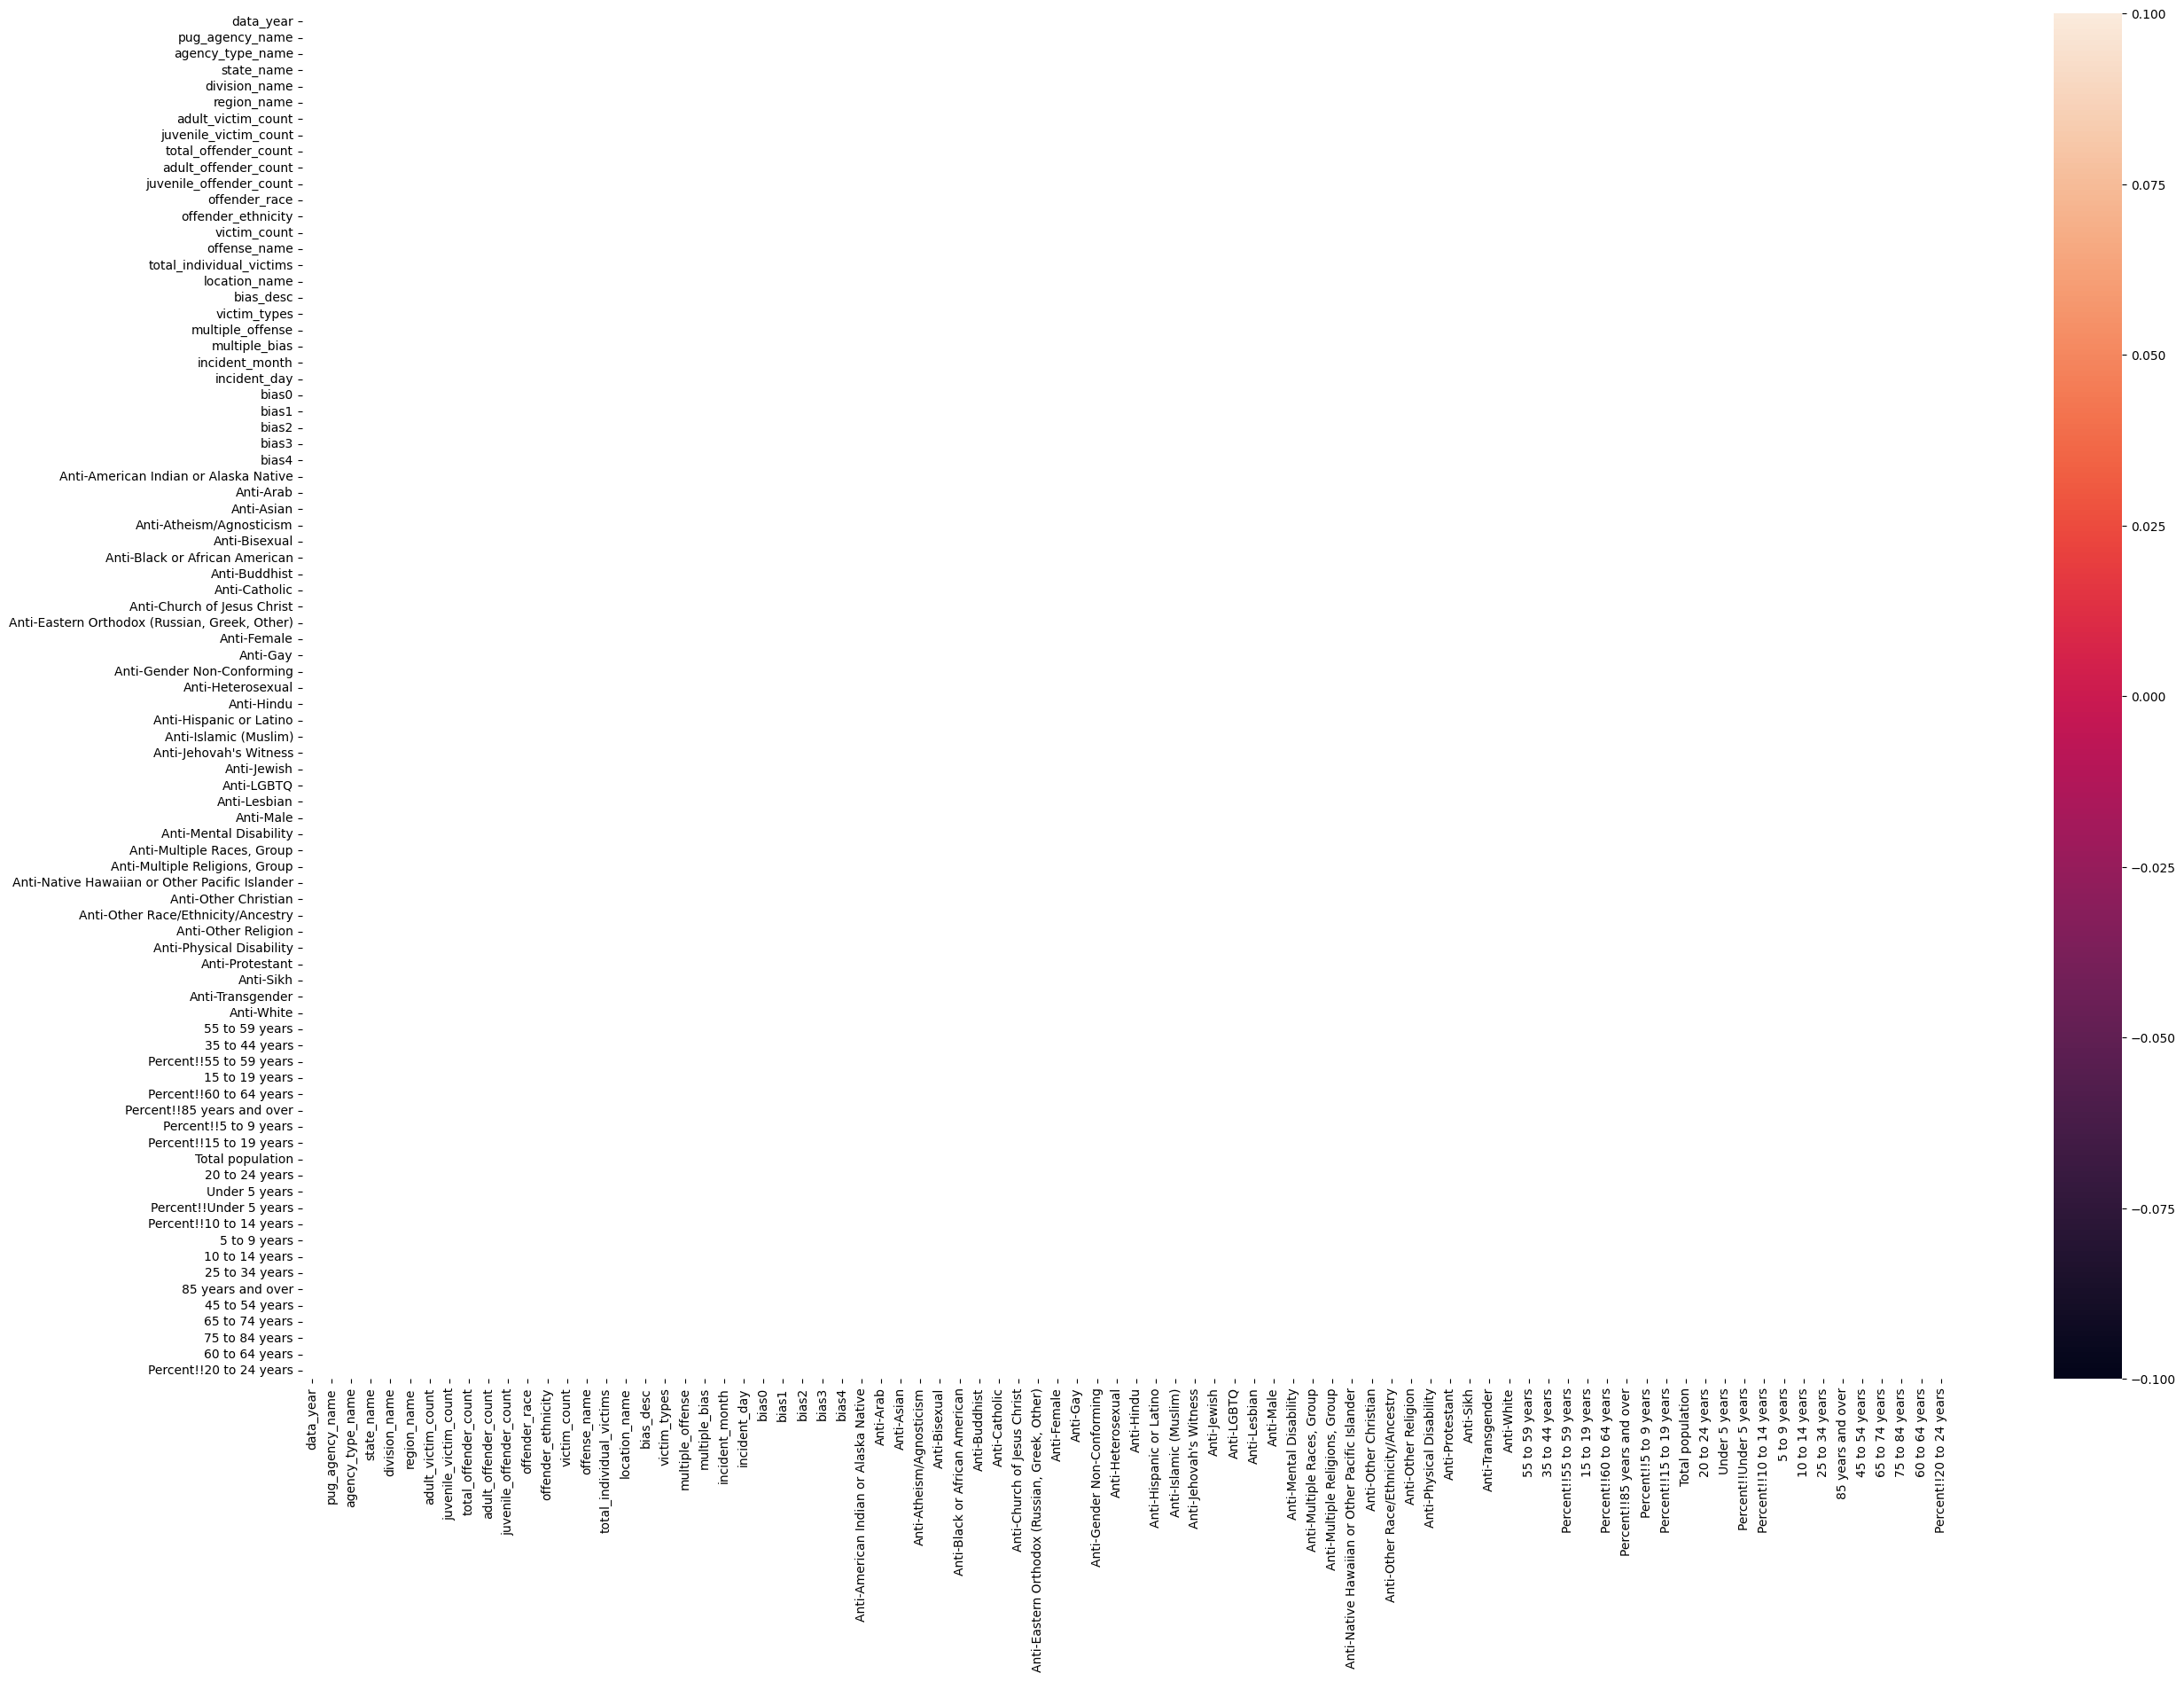

In [40]:
# Create a correlation matrix
corr = merged_df[numerical_cols.columns].corr()

# Create a heatmap of the correlation matrix
fig, ax = plt.subplots(figsize=(30,20))
sns.heatmap(corr, annot=True, ax=ax)

In [41]:
merged_df["color"] = merged_df["region_name"].map({
    "Midwest": "red",
    "West": "yellow",
    "Northeast": "green",
    "South": "blue"
})
merged_df["size"] = merged_df.groupby(["incident_month", "region_name"]).count().reset_index()["incident_id"]

#remove the max row limit for altair
alt.data_transformers.disable_max_rows()

alt.Chart(merged_df.dropna()).mark_circle().encode(
    x="total_offender_count",
    y="total_individual_victims",
    color=alt.Color("color", scale=None),
    size="size"
)

/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:219: UserWarning: I don't know how to infer vegalite type from 'empty'.  Defaulting to nominal.
  warnings.warn(


alt.Chart(...)